# TRANSFER LEARNING INCEPTION v3

- Try custom classifier

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, utils, callbacks
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [3]:
print("Tensorflow version: ", tf.__version__)
print("Keras version: ", keras.__version__)

Tensorflow version:  2.1.0
Keras version:  2.2.4-tf


In [4]:
image_shape = (299, 299, 3)
batch_size = 32
epoch = 50
seed_generator = 123
lr_init = 1e-4

In [5]:
def plot_training(history):
    acc = history.history["categorical_accuracy"]
    val_acc = history.history["val_categorical_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label="training acc")
    plt.plot(epochs, val_acc, label="valid acc")
    plt.title("Training & valid Accuracy")
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label="training loss")
    plt.plot(epochs, val_loss, label="valid loss")
    plt.title("Training & valid Loss")
    plt.legend()
    plt.show()

#  Prepare dataset

In [6]:
base_dir = "aptos2019_balance_set_new_rescaled_300/"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "validation")

In [7]:
conv_base = InceptionV3(include_top=False,
                        weights="imagenet",
                        input_shape=image_shape)

conv_base.trainable = False
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
train_datagen = image.ImageDataGenerator(data_format="channels_last")
test_datagen = image.ImageDataGenerator(data_format="channels_last")

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_shape[0:2],
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=seed_generator)

valid_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=image_shape[0:2],
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=seed_generator)

Found 750 images belonging to 5 classes.
Found 115 images belonging to 5 classes.


In [10]:
my_callbacks = [
    callbacks.CSVLogger("logging_without_augmentation.csv", append=True)
]

# Check Train Dataset

In [11]:
train_generator[0][0].shape

(32, 299, 299, 3)

In [12]:
image_idx = train_generator.index_array[1]
train_generator.labels[image_idx]

3

In [13]:
train_generator.filepaths[image_idx]

'aptos2019_balance_set_new_rescaled_300/train\\3_severe\\6d0c0531083f.png'

In [14]:
train_images_7, train_labels_7 = train_generator[7]
print(train_images_7.shape)
print(train_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

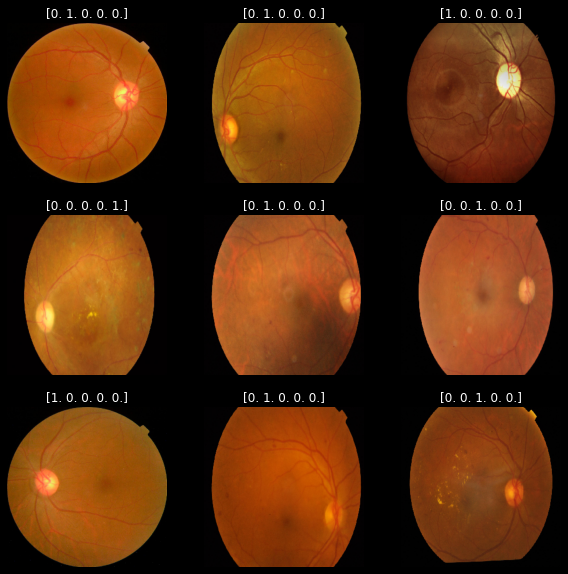

In [15]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(train_images_7[idx]))
    plt.title(str(train_labels_7[idx]))
    plt.axis("off")

plt.show

# Check Validation Dataset

In [16]:
valid_generator[0][0].shape

(32, 299, 299, 3)

In [17]:
image_idx = valid_generator.index_array[1]
valid_generator.labels[image_idx]

3

In [18]:
valid_generator.filepaths[image_idx]

'aptos2019_balance_set_new_rescaled_300/validation\\3_severe\\bf8092e4001d.png'

In [19]:
valid_images_7, valid_labels_7 = valid_generator[3]
print(train_images_7.shape)
print(train_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


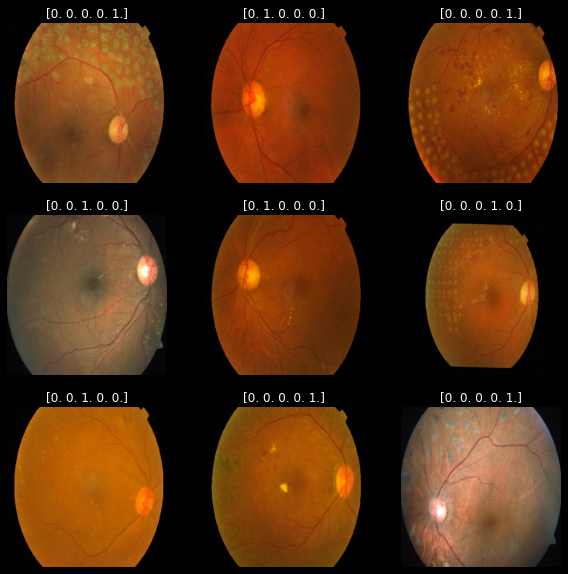

In [20]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(valid_images_7[idx]))
    plt.title(str(valid_labels_7[idx]))
    plt.axis("off")

# Training Model

## Fast.ai Classifier Modified

Source: https://fastai1.fast.ai/vision.learner.html#cnn_learner


In [21]:
try:
    del (model)
except:
    pass

In [22]:
input_layer = keras.Input(shape=(image_shape))
x = preprocess_input(input_layer)
x = conv_base(x, training=False)
x1 = layers.GlobalAveragePooling2D()(x)
x2 = layers.GlobalMaxPooling2D()(x)
x = layers.Concatenate()([x1, x2])
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5)(x)
output_layer = layers.Activation("softmax")(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)

In [23]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(learning_rate=lr_init),
              metrics=["categorical_accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

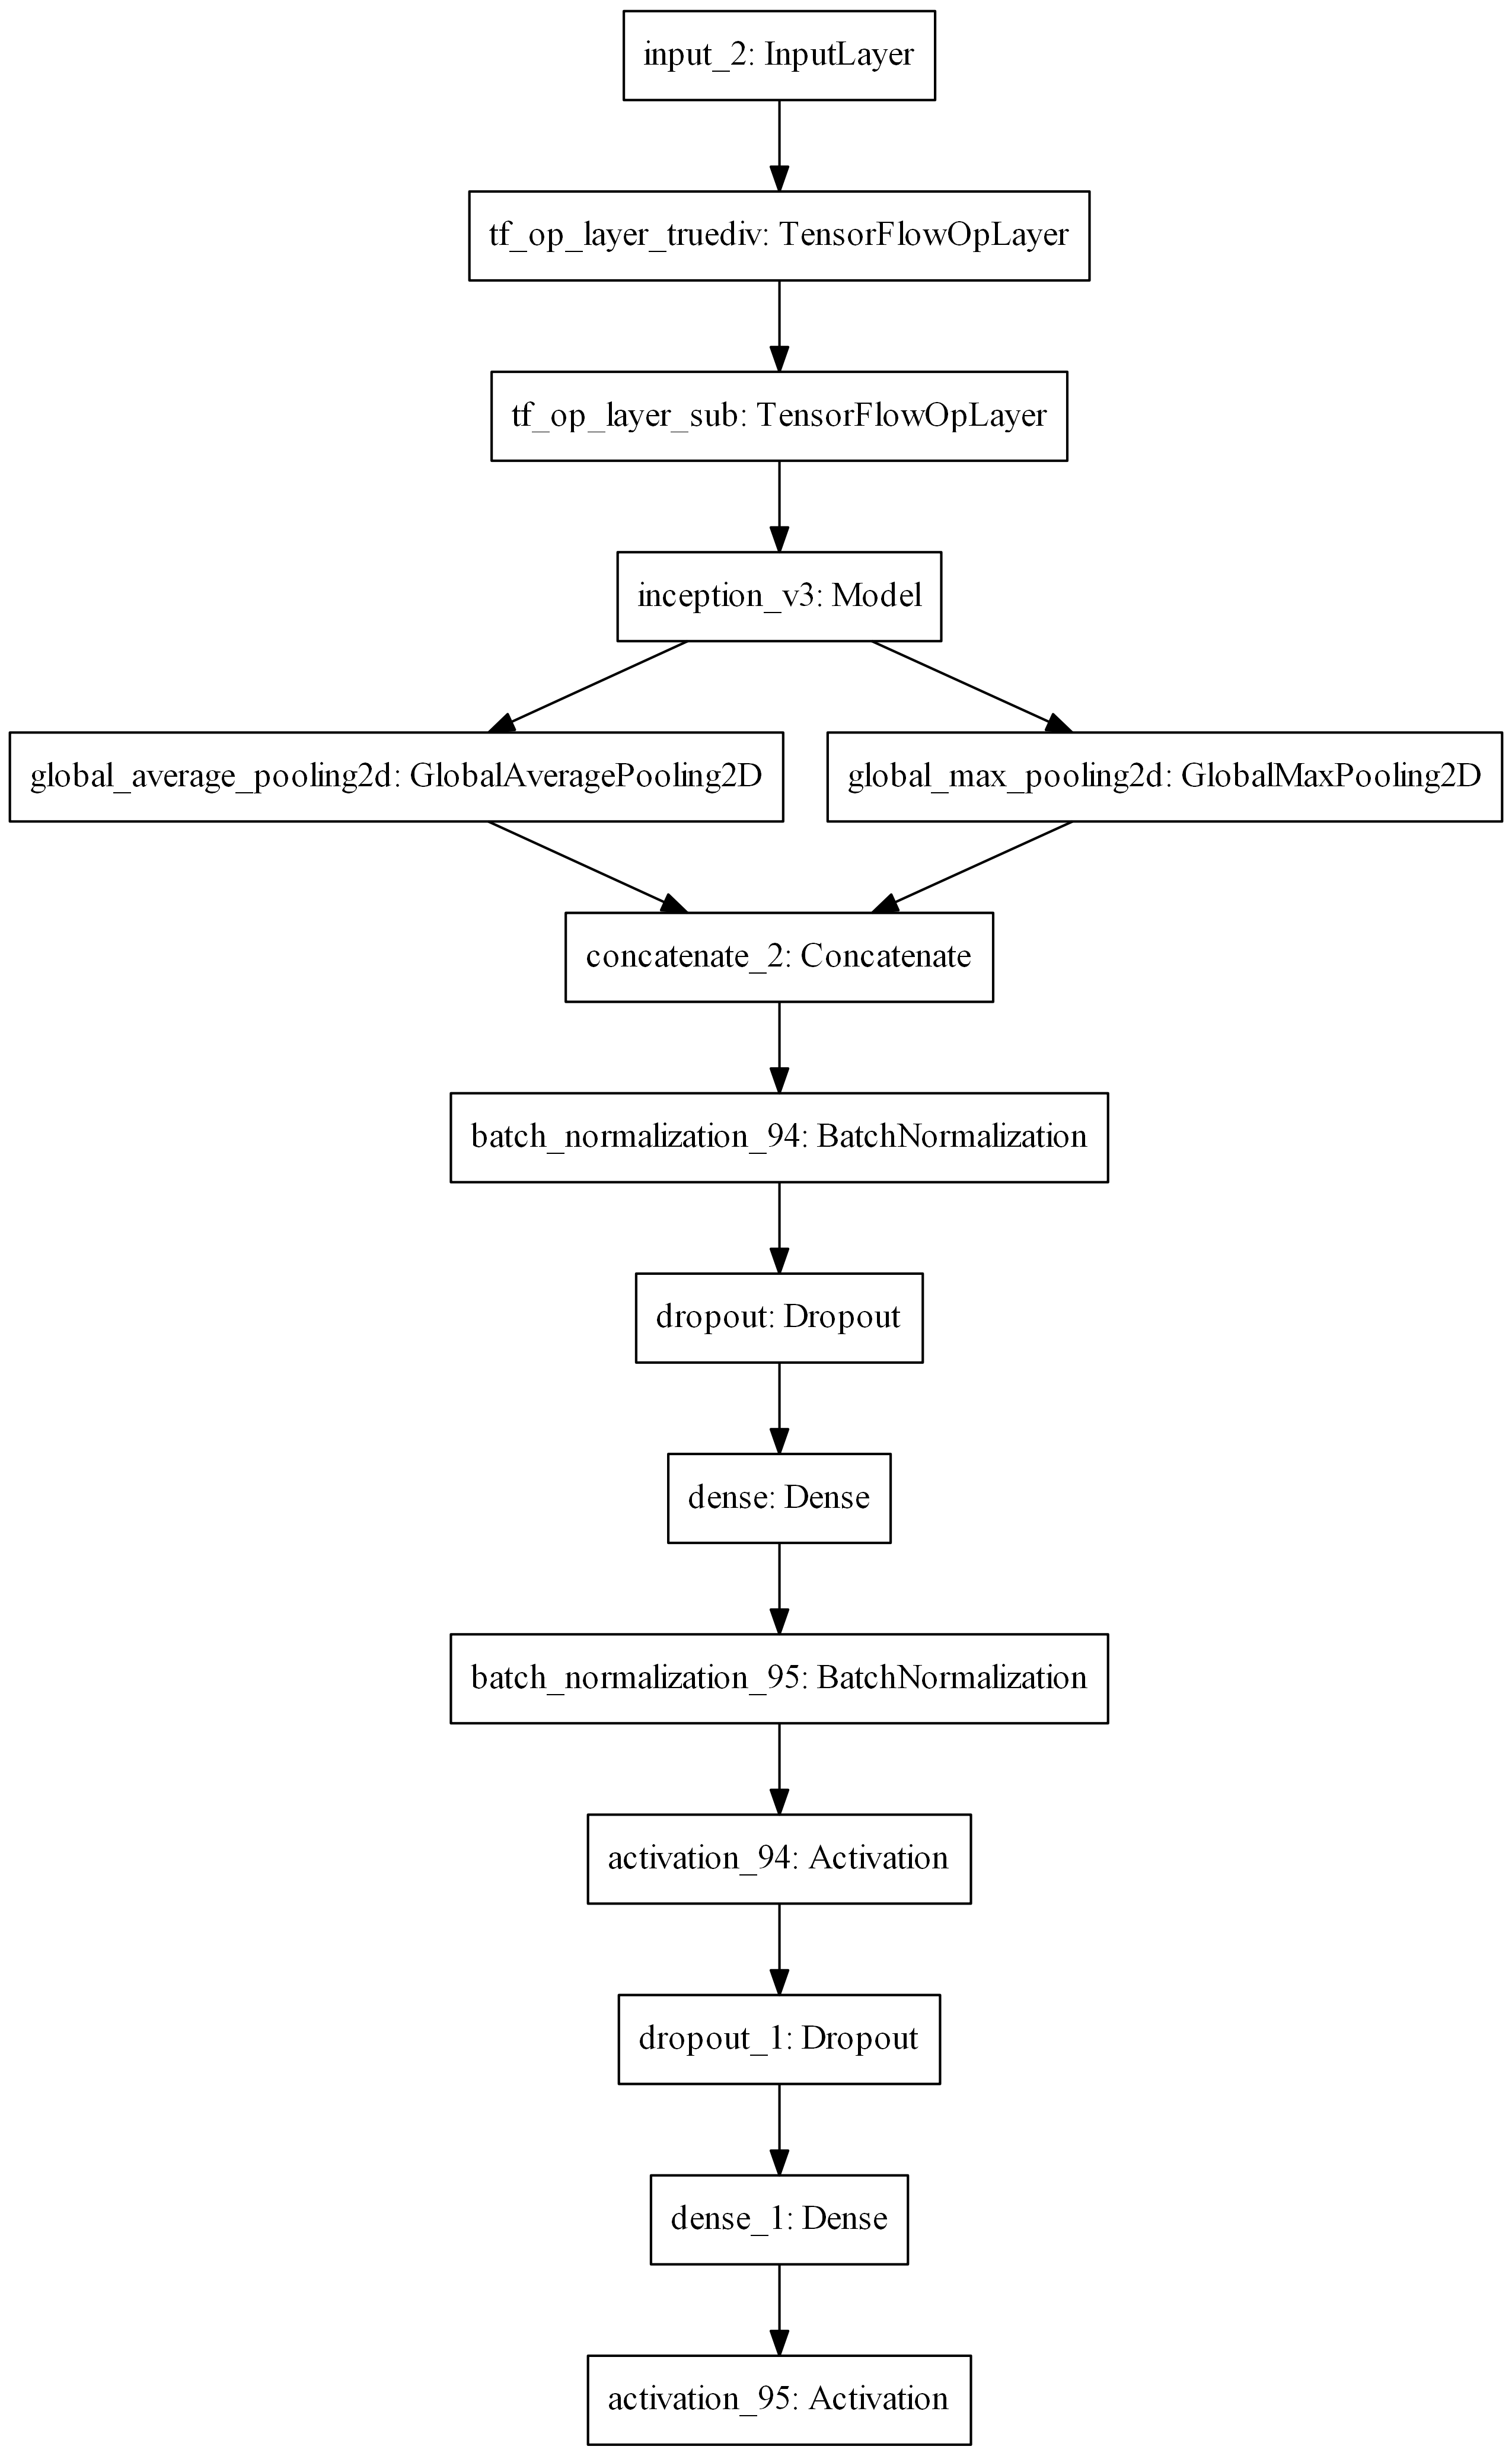

In [24]:
utils.plot_model(model, dpi=300)

In [25]:
history = model.fit(train_generator,
                    epochs=epoch,
                    validation_data=valid_generator,
                    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 4 steps
Epoch 1/50
24/24 [==============================] - 34s 1s/step - loss: 1.8967 - categorical_accuracy: 0.2867 - val_loss: 1.5086 - val_categorical_accuracy: 0.3826
Epoch 2/50
24/24 [==============================] - 14s 576ms/step - loss: 1.3745 - categorical_accuracy: 0.4773 - val_loss: 1.3970 - val_categorical_accuracy: 0.4087
Epoch 3/50
24/24 [==============================] - 13s 537ms/step - loss: 1.1792 - categorical_accuracy: 0.5293 - val_loss: 1.2586 - val_categorical_accuracy: 0.4522
Epoch 4/50
24/24 [==============================] - 13s 547ms/step - loss: 1.0703 - categorical_accuracy: 0.5907 - val_loss: 1.1815 - val_categorical_accuracy: 0.4957
Epoch 5/50
24/24 [==============================] - 13s 547ms/step - loss: 0.9997 - categorical_accuracy: 0.6040 - val_loss: 1.1306 - val_categorical_accuracy: 0.5391
Epoch 6/50
24/24 [==============================] - 14s 565ms/step - loss: 0.

In [26]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
4/4 [==============================] - 2s 494ms/step - loss: 0.9563 - categorical_accuracy: 0.6261


[0.9562913775444031, 0.62608695]

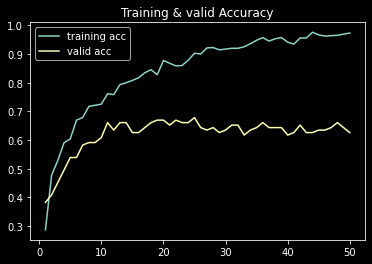

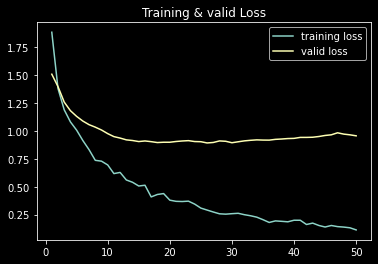

In [27]:
plot_training(history)